# Preparing Data with PCA

In [6]:
import scipy
import scipy.ndimage
import matplotlib.pyplot as plt 
import os
import numpy as np 
from os import walk
from PIL import Image
from matplotlib.pyplot import imread

In [10]:
!pip install -q kaggle

In [3]:
from google.colab import files

ModuleNotFoundError: No module named 'google.colab'

In [5]:
files.upload()

NameError: name 'files' is not defined

In [11]:
! cp kaggle.json ~/.kaggle/

cp: directory /Users/sultanbeishenkulov/.kaggle does not exist


In [9]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: /Users/sultanbeishenkulov/.kaggle/kaggle.json: No such file or directory


In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog

In [ ]:
!unzip '/content/cat-and-dog.zip'

In [13]:
if not os.path.exists(os.path.join('DATA_WITH_PCA_30','training_set','dogs')):

    os.makedirs(os.path.join('DATA_WITH_PCA_30','training_set','dogs'))
    os.makedirs(os.path.join('DATA_WITH_PCA_30','training_set','cats'))

In [14]:
def comp_2d(image_2d): # FUNCTION FOR RECONSTRUCTING 2D MATRIX USING PCA
	cov_mat = image_2d - np.mean(image_2d , axis =None)
	eig_val, eig_vec = np.linalg.eigh(np.cov(cov_mat))
    # USING "eigh", SO THAT PROPRTIES OF HERMITIAN MATRIX CAN BE USED
	p = np.size(eig_vec, axis =None)
	idx = np.argsort(eig_val)
	idx = idx[::-1]
	eig_vec = eig_vec[:,idx]
	eig_val = eig_val[idx]
	numpc = 40 
    # THIS IS NUMBER OF PRINCIPAL COMPONENTS, YOU CAN CHANGE IT AND SEE RESULTS
	if numpc <p or numpc >0:
		eig_vec = eig_vec[:, range(numpc)]
	score = np.dot(eig_vec.T, cov_mat)
	recon = np.dot(eig_vec, score) + np.mean(image_2d, axis = None).T
    # SOME NORMALIZATION CAN BE USED TO MAKE IMAGE QUALITY BETTER
	recon_img_mat = np.uint8(np.absolute(recon)) 
    # TO CONTROL COMPLEX EIGENVALUES
	return recon_img_mat

In [15]:
os.remove("/content/training_set/training_set/dogs/_DS_Store")
os.remove("/content/training_set/training_set/cats/_DS_Store")

In [16]:
_, _, filenames_dog = next(walk('/content/training_set/training_set/dogs'))
_, _, filenames_cat = next(walk('/content/training_set/training_set/cats'))

In [17]:
for image in filenames_dog:
    a = imread('/content/training_set/training_set/dogs/'+image)
    a_np = np.array(a)
    a_r = a_np[:,:,0]
    a_g = a_np[:,:,1]
    a_b = a_np[:,:,2]
    a_r_recon, a_g_recon, a_b_recon = comp_2d(a_r), comp_2d(a_g), comp_2d(a_b) # RECONSTRUCTING R,G,B COMPONENTS SEPARATELY
    recon_color_img = np.dstack((a_r_recon, a_g_recon, a_b_recon)) # COMBINING R.G,B COMPONENTS TO PRODUCE COLOR IMAGE
    recon_color_img = Image.fromarray(recon_color_img)
    recon_color_img.show()
    recon_color_img = recon_color_img.save("/content/DATA_WITH_PCA_30/training_set/dogs/"+image[:-4]+".jpg")

In [18]:
for image in filenames_cat:
    a = imread('/content/training_set/training_set/cats/'+image)
    a_np = np.array(a)
    a_r = a_np[:,:,0]
    a_g = a_np[:,:,1]
    a_b = a_np[:,:,2]
    a_r_recon, a_g_recon, a_b_recon = comp_2d(a_r), comp_2d(a_g), comp_2d(a_b) # RECONSTRUCTING R,G,B COMPONENTS SEPARATELY
    recon_color_img = np.dstack((a_r_recon, a_g_recon, a_b_recon)) # COMBINING R.G,B COMPONENTS TO PRODUCE COLOR IMAGE
    recon_color_img = Image.fromarray(recon_color_img)
    recon_color_img.show()
    recon_color_img = recon_color_img.save("/content/DATA_WITH_PCA_30/training_set/cats/"+image[:-4]+".jpg")

# Modeling Without PCA

In [19]:
import warnings
warnings.filterwarnings('ignore')

# Setting up our enviroment
# Data Viz & Regular Expression Libraries :
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import FastAI library 
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os

In [20]:
x  = '/content/training_set/training_set'
path = Path(x)
path.ls()

[PosixPath('/content/training_set/training_set/dogs'),
 PosixPath('/content/training_set/training_set/cats')]

In [21]:
np.random.seed(40)
data = ImageDataBunch.from_folder(path, train = '.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224,
                                  num_workers=4).normalize(imagenet_stats)

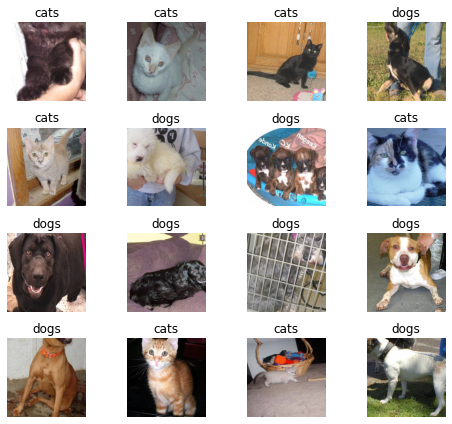

In [22]:
data.show_batch(rows=4, figsize=(7,6),recompute_scale_factor=True)

In [23]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy],path = Path("."))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [24]:
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(4,slice(lr1,lr2))

epoch,train_loss,valid_loss,accuracy,time
0,0.472111,0.694137,0.945659,01:32
1,0.388817,0.260958,0.964397,01:32
2,0.149345,0.058858,0.980012,01:33
3,0.067039,0.048414,0.980637,01:33


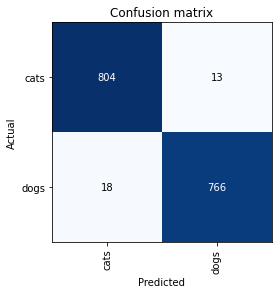

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**Prediction using trained model**

cats


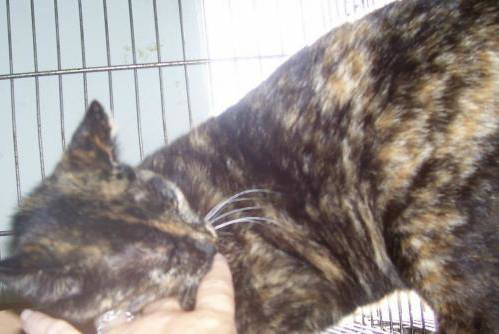

In [26]:
img = open_image('/content/test_set/test_set/cats/cat.4006.jpg')
print(learn.predict(img)[0])
img

# With PCA

In [27]:
x  = '/content/DATA_WITH_PCA_30/training_set'
path = Path(x)
path.ls()

[PosixPath('/content/DATA_WITH_PCA_30/training_set/dogs'),
 PosixPath('/content/DATA_WITH_PCA_30/training_set/cats')]

In [28]:
np.random.seed(40)
data = ImageDataBunch.from_folder(path, train = '.', valid_pct=0.2,
                                  ds_tfms=get_transforms(), size=224,
                                  num_workers=4).normalize(imagenet_stats)

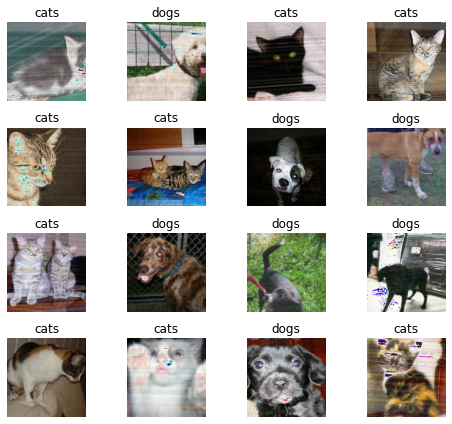

In [29]:
data.show_batch(rows=4, figsize=(7,6),recompute_scale_factor=True)

In [30]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy],path = Path("."))

In [31]:
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(4,slice(lr1,lr2))

epoch,train_loss,valid_loss,accuracy,time
0,0.456152,1.466753,0.853217,01:36
1,0.379530,0.164812,0.957527,01:34
2,0.157225,0.088773,0.965022,01:33
3,0.080869,0.080694,0.971268,01:33


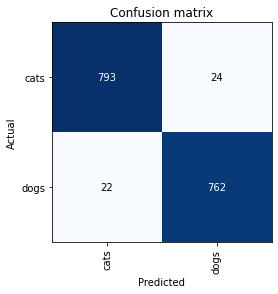

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**Interpretation:**
1. So here we trained two model the 1st one without applying PCA on the data and the 2nd one after performing PCA and we noticed that The model without PCA is performing better as we see accuracy for the 1st one is 0.98 and for the 2nd one is 0.971.
2. In term of log loss also the 1st one is better.
3. The confusion matrix also show that the 1st model is better.